In [58]:
# Import required packages
import matplotlib.pyplot as plt
from skimage import io
from skimage import data, img_as_float
import skimage.restoration as skiresort

from skimage.restoration import denoise_wavelet
                                 
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

import numpy as np
import scipy
import os
import pywt

import numbers
from skimage.color import rgb2gray


In [59]:
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.1.0' #path to R installation (not neeeded in all cases)

In [60]:
# To run custom R code
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
from rpy2.rinterface import NULL, NA

# To export data
import pickle 

# For data processing
import pandas as pd

In [61]:
# Define noise level
sigma = 0.05

In [62]:
# Read image
filename = os.path.join('output\\figures\\stjerten256.png')
out_path = "output/image-de-noising/"
image = io.imread(filename)
image = image/255.

# Add noise
noisy = random_noise(image, var=sigma**2, seed = 1, mode = "gaussian")





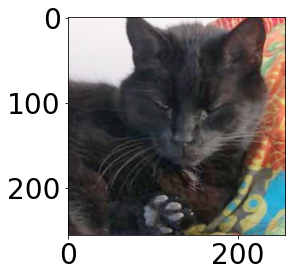

In [63]:
plt.imshow(image)


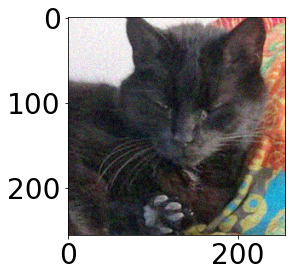

In [64]:
# Image with noise
plt.imshow(noisy)


In [65]:
# Define R functions
itses = importr('itses') # For SparseMAD() as itses()
r_sparse_mad = robjects.r['sparse.mad.estimator']

r_source = robjects.r['source']
r_source("R-utility/extra-utility.R")
est_ss  = robjects.r['get.sureshrink.threshold']
est_iterative = robjects.r['itses_saved']


In [66]:
# Define custom thresholding functions

# Iterative estimation with soft threshold starting at median
def itses_st(x, sd, store_iterations = True, name = None):
    x = np.ndarray.flatten(x)

    savepath = NULL
    if name: 
        savepath = "output/image-de-noising/wavelets-st/" + name + str(len(x)) + ".RData"
    
    x_vec = FloatVector(x)
    sd_vec = FloatVector([sd])
    threshold = est_iterative(x_vec, 
                             method ="ST",
                             sd = sd_vec,
                             sparse_mad = True, 
                             savepath = savepath,
                             debug = True
                            )[1]
    return threshold[0]

# Iteartive estimation with hard threshold starting at median
def itses_ht(x, sd, store_iterations = True, name = None):
    x = np.ndarray.flatten(x)

    savepath = NULL
    if name: 
        savepath = "output/image-de-noising/wavelets-ht/" + name + str(len(x)) + ".RData"
    
    x_vec = FloatVector(x)
    sd_vec = FloatVector([sd])
    threshold = est_iterative(x_vec, 
                             method ="HT",
                             sd = sd_vec,
                             sparse_mad = True, 
                             savepath = savepath,
                             debug = True
                             )[1]
    
    return threshold[0]

# Run SureShrink from R package ASUS.
def ss(x, sd):
    x = np.ndarray.flatten(x)
    z = x/sd
    z_vec = FloatVector(z)
    threshold = est_ss(z_vec)[0]
    return threshold*sd

# Estiamte noise with SparseMAD
def sparse_mad (detail_coeffs, distribution='Gaussian'):
    detail_coeffs = detail_coeffs[np.nonzero(detail_coeffs)]

    if distribution.lower() != 'gaussian':
        raise ValueError("Only Gaussian noise estimation is currently "
                         "supported")
        
    x = np.ndarray.flatten(detail_coeffs)
    x_vec = FloatVector(x)
    sigma = r_sparse_mad(x_vec, debug = True)[0]
    return sigma


In [67]:
# Implement custom wavelet denoising based on scikit-image, mostly copy paste from scikit-image source code. 
# scikit-imaage source code can be found at e.g. https://github.com/scikit-image/scikit-image
# New custom code will be higlighted
def _sigma_est_dwt(detail_coeffs, distribution='Gaussian'):
    detail_coeffs = detail_coeffs[np.nonzero(detail_coeffs)]

    if distribution.lower() == 'gaussian':
        # 75th quantile of the underlying, symmetric noise distribution
        denom = scipy.stats.norm.ppf(0.75)
        sigma = np.median(np.abs(detail_coeffs)) / denom
    else:
        raise ValueError("Only Gaussian noise estimation is currently "
                         "supported")
    return sigma

def _scale_sigma_and_image_consistently(image, sigma, multichannel,
                                        rescale_sigma):
    if multichannel:
        if isinstance(sigma, numbers.Number) or sigma is None:
            sigma = [sigma] * image.shape[-1]
        elif len(sigma) != image.shape[-1]:
            raise ValueError(
                "When multichannel is True, sigma must be a scalar or have "
                "length equal to the number of channels")
    if image.dtype.kind != 'f':
        if rescale_sigma:
            range_pre = image.max() - image.min()
        image = img_as_float(image)
        if rescale_sigma:
            range_post = image.max() - image.min()
            # apply the same magnitude scaling to sigma
            scale_factor = range_post / range_pre
            if multichannel:
                sigma = [s * scale_factor if s is not None else s
                         for s in sigma]
            elif sigma is not None:
                sigma *= scale_factor
    elif image.dtype == np.float16:
        image = image.astype(np.float32)
    return image, sigma
def _bayes_thresh(details, var):
    """BayesShrink threshold for a zero-mean details coeff array."""
    # Equivalent to:  dvar = np.var(details) for 0-mean details array
    dvar = np.mean(details*details)
    eps = np.finfo(details.dtype).eps
    thresh = var / np.sqrt(max(dvar - var, eps))
    return thresh
def _universal_thresh(img, sigma):
    """ Universal threshold used by the VisuShrink method """
    return sigma*np.sqrt(2*np.log(img.size))


def _wavelet_threshold(image, wavelet, method='IterativeST', threshold=None,
                       sigma=None, mode='soft', wavelet_levels=None, use_sparse_mad_estimation = False, name = None):
    # Note that arguments of _wavelet_threshold is slightly altered from original

    wavelet = pywt.Wavelet(wavelet)

    original_extent = tuple(slice(s) for s in image.shape)

    # Determine the number of wavelet decomposition levels
    if wavelet_levels is None:
        # Determine the maximum number of possible levels for image
        dlen = wavelet.dec_len
        wavelet_levels = pywt.dwtn_max_level(image.shape, wavelet)

        # Skip coarsest wavelet scales (see Notes in docstring).
        wavelet_levels = max(wavelet_levels - 3, 1)

    coeffs = pywt.wavedecn(image, wavelet=wavelet, level=wavelet_levels)
    # Detail coefficients at each decomposition level
    dcoeffs = coeffs[1:]

    #!! Custom Code Start !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Add the option of using SparseMAD noise estimation (done across all bands in)
    if sigma is None:
        # Estimate the noise via the method in [2]_
        detail_coeffs = dcoeffs[-1]['d' * image.ndim]
        print("Number of points in noise estimation:", len(detail_coeffs))
        if not use_sparse_mad_estimation:
            sigma = _sigma_est_dwt(detail_coeffs, distribution='Gaussian') 
        else: 
            sigma = sparse_mad(detail_coeffs, distribution='Gaussian') 
        print("Estimated noise:", sigma)
    #!! Custom Code End !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
    if method is not None and threshold is not None:
        warn(("Thresholding method {} selected.  The user-specified threshold "
              "will be ignored.").format(method))
        
    #!! Custom Code Start !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Output the wavelet coefficitnes to study in R (before thresholding)
    if name:
        print("Storing waves")
        data = dcoeffs[len(dcoeffs)-2]
        data = np.array([np.ndarray.flatten(data[level]) for level in data])
        data = np.transpose(data)  
        np.savetxt(out_path + name + ".csv", data, delimiter=",")
    #!! Custom Code End !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    if threshold is None:
        print(sigma)
        var = sigma**2
        if method is None:
            raise ValueError(
                "If method is None, a threshold must be provided.")
        elif method == "BayesShrink":
            # The BayesShrink thresholds from [1]_ in docstring
            threshold = [{key: _bayes_thresh(level[key], var) for key in level}
                         for level in dcoeffs]
        elif method == "VisuShrink":
            # The VisuShrink thresholds from [2]_ in docstring
            threshold = _universal_thresh(image, sigma)
        #!! Custom Code Start !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        ## Injecting custom thresholding methods, ITSES-ST, ITSES-HT, and SureShrink
        elif method == "IterativeST":
            if name:
                threshold = [{key: itses_st(level[key], sigma, name = name+key) for key in level}
                             for level in dcoeffs]
            else:
                threshold = [{key: itses_st(level[key], sigma, name = None) for key in level}
                             for level in dcoeffs]
        elif method == "IterativeHT":
            mode = 'hard'
            if name:
                threshold = [{key: itses_ht(level[key], sigma, name = name+key) for key in level}
                             for level in dcoeffs]
            else: 
                threshold = [{key: itses_ht(level[key], sigma, name = None) for key in level}
                             for level in dcoeffs]
        elif method == "SureShrink":
            threshold = [{key: ss(level[key], sigma) for key in level}
                         for level in dcoeffs]
        #!! Custom Code End !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        else:
            raise ValueError("Unrecognized method: {}".format(method))
            
            
    #!! Custom Code Start !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Print found thresholds for debugging
    print("threshold is:")
    print(threshold)
    #!! Custom Code End !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
   
   
    if np.isscalar(threshold):        
        denoised_detail = [{key: pywt.threshold(level[key],
                                                value=threshold,
                                                mode=mode) for key in level}
                           for level in dcoeffs]
    else:        
        denoised_detail = [{key: pywt.threshold(level[key],
                                                value=thresh[key],
                                                mode=mode) for key in level}
                           for thresh, level in zip(threshold, dcoeffs)]
    denoised_coeffs = [coeffs[0]] + denoised_detail
    return pywt.waverecn(denoised_coeffs, wavelet)[original_extent]
def denoise_wavelet(image, sigma=None, wavelet='db1', mode='soft',
                    wavelet_levels=None, multichannel=False,
                    convert2ycbcr=False, method='BayesShrink',
                    rescale_sigma=True, *, channel_axis=None,
                   use_sparse_mad_estimation = False, name = None):
    multichannel = channel_axis is not None


    # floating-point inputs are not rescaled, so don't clip their output.
    clip_output = image.dtype.kind != 'f'

    if convert2ycbcr and not multichannel:
        raise ValueError("convert2ycbcr requires multichannel == True")

    image, sigma = _scale_sigma_and_image_consistently(image,
                                                       sigma,
                                                       multichannel,
                                                       rescale_sigma)
    
    if multichannel:
        if convert2ycbcr:
            out = color.rgb2ycbcr(image)
            # convert user-supplied sigmas to the new colorspace as well
            if rescale_sigma:
                sigma = _rescale_sigma_rgb2ycbcr(sigma)
            for i in range(3):
                # renormalizing this color channel to live in [0, 1]
                _min, _max = out[..., i].min(), out[..., i].max()
                scale_factor = _max - _min
                if scale_factor == 0:
                    # skip any channel containing only zeros!
                    continue
                channel = out[..., i] - _min
                channel /= scale_factor
                sigma_channel = sigma[i]
                if sigma_channel is not None:
                    sigma_channel /= scale_factor
                out[..., i] = denoise_wavelet(channel,
                                              wavelet=wavelet,
                                              method=method,
                                              sigma=sigma_channel,
                                              mode=mode,
                                              wavelet_levels=wavelet_levels,
                                              rescale_sigma=rescale_sigma)
                out[..., i] = out[..., i] * scale_factor
                out[..., i] += _min
            out = color.ycbcr2rgb(out)
        else:
            out = np.empty_like(image)
            for c in range(image.shape[-1]):
                print("Thresholding color: ", c)
                print("Shape", np.shape(image[..., c]))
                if(name):
                    name = name+"channel_"+str(c)
                out[..., c] = _wavelet_threshold(image[..., c],
                                                 wavelet=wavelet,
                                                 method=method,
                                                 sigma=sigma[c], mode=mode,
                                                 wavelet_levels=wavelet_levels,
                                                use_sparse_mad_estimation =use_sparse_mad_estimation, 
                                                name = name)
    else:
        out = _wavelet_threshold(image, wavelet=wavelet, method=method,
                                 sigma=sigma, mode=mode,
                                 wavelet_levels=wavelet_levels,
                                use_sparse_mad_estimation = use_sparse_mad_estimation, 
                                 name = name)

    if clip_output:
        clip_range = (-1, 1) if image.min() < 0 else (0, 1)
        out = np.clip(out, *clip_range, out=out)
    return out

In [88]:
# Run deafault methods 
bayes_image= denoise_wavelet(noisy, method ="BayesShrink", multichannel = True, channel_axis = 2)
visu_image = denoise_wavelet(noisy, method ="VisuShrink", multichannel = True, channel_axis = 2)


Thresholding color:  0
Shape (256, 256)
Number of points in noise estimation: 128
Estimated noise: 0.048954292373881686
0.048954292373881686
threshold is:
[{'ad': 0.0011924529929773654, 'da': 0.0009935492567089404, 'dd': 0.0029021664365499805}, {'ad': 0.002713611829329278, 'da': 0.003400463166017473, 'dd': 0.0066070822006924395}, {'ad': 0.007724147983667356, 'da': 0.00918484538490239, 'dd': 0.0207147923317637}, {'ad': 0.02513514786095597, 'da': 0.025005714078023662, 'dd': 0.06495403120727819}, {'ad': 0.07959383310984845, 'da': 0.07846722709411866, 'dd': 0.26790872791325093}]
Thresholding color:  1
Shape (256, 256)
Number of points in noise estimation: 128
Estimated noise: 0.05094729532221254
0.05094729532221254
threshold is:
[{'ad': 0.0015009990112639221, 'da': 0.001167978928470613, 'dd': 0.00333056705931487}, {'ad': 0.0034366325354635106, 'da': 0.003946539911379332, 'dd': 0.007231800551668552}, {'ad': 0.00900130151407761, 'da': 0.010535118944067088, 'dd': 0.02248760038294107}, {'ad': 

In [72]:
%%time 
itses_image_st = denoise_wavelet(noisy, method ="IterativeST", use_sparse_mad_estimation = False, name = "stjerten_st_", multichannel = True, channel_axis = 2)


Thresholding color:  0
Shape (256, 256)
Number of points in noise estimation: 128
Estimated noise: 0.048954292373881686
Storing waves
0.048954292373881686
[1] "Starting ITSES. Number of points in data:  64"
[1] "Using gaussian noise"
[1] "Sd:0.0489542923738817"
[1] "Threshold bounds are set to: 0 2.88405377320177"
[1] "Iteration: 0 Threshold: 2.88405377320177"
[1] "Starting iterative with newton 2.88405377320177"
[1] "Starting newton at: 0"
[1] "Newton iter: 1, lambda:0.176400108808844, diff to last: 0.176"
[1] "Newton iter: 2, lambda:0.180054645617725, diff to last: 0.004"
[1] "Newton iter: 3, lambda:0.180056203548621, diff to last: 0"
[1] "Newton iter: 4, lambda:0.180056203548904, diff to last: 0"
[1] "Iteration: 1 Threshold: 0.180056203548621"
[1] "Starting iterative with newton 0.180056203548621"
[1] "Starting newton at: 0"
[1] "Newton iter: 1, lambda:0.0752390304947841, diff to last: 0.075"
[1] "Newton iter: 2, lambda:0.0756736924962189, diff to last: 0"
[1] "Newton iter: 3, lambd

[1] "Iteration: 4 Threshold: 0.153939476025984"
[1] "Starting iterative with newton 0.153939476025984"
[1] "Starting newton at: 0"
[1] "Newton iter: 1, lambda:0.150628532528513, diff to last: 0.151"
[1] "Newton iter: 2, lambda:0.153710979438385, diff to last: 0.003"
[1] "Newton iter: 3, lambda:0.153712267277921, diff to last: 0"
[1] "Newton iter: 4, lambda:0.153712267278146, diff to last: 0"
[1] "Final threshold is: 0.00752487527377558"
[1] "Starting ITSES. Number of points in data:  256"
[1] "Using gaussian noise"
[1] "Sd:0.0489542923738817"
[1] "Threshold bounds are set to: 0 3.33021844463079"
[1] "Iteration: 0 Threshold: 3.33021844463079"
[1] "Starting iterative with newton 3.33021844463079"
[1] "Starting newton at: 0.363990194173408"
[1] "Newton iter: 1, lambda:0.441115721984976, diff to last: 0.077"
[1] "Newton iter: 2, lambda:0.442742184272795, diff to last: 0.002"
[1] "Newton iter: 3, lambda:0.44274289660255, diff to last: 0"
[1] "Newton iter: 4, lambda:0.442742896602687, diff t

[1] "Newton iter: 1, lambda:0.393229392847603, diff to last: 0.047"
[1] "Newton iter: 2, lambda:0.393937792123365, diff to last: 0.001"
[1] "Newton iter: 3, lambda:0.393937956060027, diff to last: 0"
[1] "Newton iter: 4, lambda:0.393937956060036, diff to last: 0"
[1] "Iteration: 3 Threshold: 0.393937956060036"
[1] "Starting iterative with newton 0.393937956060036"
[1] "Starting newton at: 0.447730507662444"
[1] "Newton iter: 1, lambda:0.381353704376736, diff to last: 0.066"
[1] "Newton iter: 2, lambda:0.382758715333101, diff to last: 0.001"
[1] "Newton iter: 3, lambda:0.382759351336707, diff to last: 0"
[1] "Newton iter: 4, lambda:0.382759351336837, diff to last: 0"
[1] "Iteration: 4 Threshold: 0.382759351336707"
[1] "Starting iterative with newton 0.382759351336707"
[1] "Starting newton at: 0.458511646705074"
[1] "Newton iter: 1, lambda:0.378162427238684, diff to last: 0.08"
[1] "Newton iter: 2, lambda:0.380209986732392, diff to last: 0.002"
[1] "Newton iter: 3, lambda:0.3802113332425

[1] "Newton iter: 4, lambda:1.29012084978892, diff to last: 0"
[1] "Newton iter: 5, lambda:1.29012084978914, diff to last: 0"
[1] "Iteration: 1 Threshold: 1.29012084978914"
[1] "Starting iterative with newton 1.29012084978914"
[1] "Starting newton at: 1.55099575361821"
[1] "Newton iter: 1, lambda:1.64161424642134, diff to last: 0.091"
[1] "Newton iter: 2, lambda:1.65302717113123, diff to last: 0.011"
[1] "Newton iter: 3, lambda:1.65319513831168, diff to last: 0"
[1] "Newton iter: 4, lambda:1.65319517425028, diff to last: 0"
[1] "Newton iter: 5, lambda:1.65319517425028, diff to last: 0"
[1] "Iteration: 2 Threshold: 1.65319517425028"
[1] "Starting iterative with newton 1.65319517425028"
[1] "Starting newton at: 1.55084178722897"
[1] "Newton iter: 1, lambda:1.7848908733085, diff to last: 0.234"
[1] "Newton iter: 2, lambda:1.87648216656042, diff to last: 0.092"
[1] "Newton iter: 3, lambda:1.88940103378556, diff to last: 0.013"
[1] "Newton iter: 4, lambda:1.88963662302107, diff to last: 0"


[1] "Newton iter: 3, lambda:0.222898611201792, diff to last: 0"
[1] "Newton iter: 4, lambda:0.22289861120703, diff to last: 0"
[1] "Iteration: 1 Threshold: 0.222898611201792"
[1] "Starting iterative with newton 0.222898611201792"
[1] "Starting newton at: 0"
[1] "Newton iter: 1, lambda:0.0927820778326337, diff to last: 0.093"
[1] "Newton iter: 2, lambda:0.0934776604021002, diff to last: 0.001"
[1] "Newton iter: 3, lambda:0.0934776994597929, diff to last: 0"
[1] "Newton iter: 4, lambda:0.093477699459793, diff to last: 0"
[1] "Iteration: 2 Threshold: 0.0934776994597929"
[1] "Starting iterative with newton 0.0934776994597929"
[1] "Starting newton at: 0"
[1] "Newton iter: 1, lambda:0.0852832273229638, diff to last: 0.085"
[1] "Newton iter: 2, lambda:0.0858490404757455, diff to last: 0.001"
[1] "Newton iter: 3, lambda:0.0858490653645984, diff to last: 0"
[1] "Newton iter: 4, lambda:0.0858490653645984, diff to last: 0"
[1] "Iteration: 3 Threshold: 0.0858490653645984"
[1] "Starting iterative w

[1] "Starting iterative with newton 3.33021844463079"
[1] "Starting newton at: 0.548900867553703"
[1] "Newton iter: 1, lambda:0.499792339257799, diff to last: 0.049"
[1] "Newton iter: 2, lambda:0.500524235498995, diff to last: 0.001"
[1] "Newton iter: 3, lambda:0.500524400313618, diff to last: 0"
[1] "Newton iter: 4, lambda:0.500524400313627, diff to last: 0"
[1] "Iteration: 1 Threshold: 0.500524400313618"
[1] "Starting iterative with newton 0.500524400313618"
[1] "Starting newton at: 0.375807826659761"
[1] "Newton iter: 1, lambda:0.194786699742228, diff to last: 0.181"
[1] "Newton iter: 2, lambda:0.200412939182388, diff to last: 0.006"
[1] "Newton iter: 3, lambda:0.200418440617405, diff to last: 0"
[1] "Newton iter: 4, lambda:0.200418440622664, diff to last: 0"
[1] "Iteration: 2 Threshold: 0.200418440617405"
[1] "Starting iterative with newton 0.200418440617405"
[1] "Starting newton at: 0.264182294256944"
[1] "Newton iter: 1, lambda:0.164199896315849, diff to last: 0.1"
[1] "Newton it

[1] "Iteration: 4 Threshold: 0.422643764227728"
[1] "Starting iterative with newton 0.422643764227728"
[1] "Starting newton at: 0.409382977464217"
[1] "Newton iter: 1, lambda:0.420070875249036, diff to last: 0.011"
[1] "Newton iter: 2, lambda:0.420110241659878, diff to last: 0"
[1] "Newton iter: 3, lambda:0.420110242193077, diff to last: 0"
[1] "Final threshold is: 0.0214034805768969"
[1] "Starting ITSES. Number of points in data:  1024"
[1] "Using gaussian noise"
[1] "Sd:0.0509472953222125"
[1] "Threshold bounds are set to: 0 3.72329741105903"
[1] "Iteration: 0 Threshold: 1.15436040460036"
[1] "Starting iterative with newton 1.15436040460036"
[1] "Starting newton at: 0.946712120924731"
[1] "Newton iter: 1, lambda:0.877941051060552, diff to last: 0.069"
[1] "Newton iter: 2, lambda:0.880772832154488, diff to last: 0.003"
[1] "Newton iter: 3, lambda:0.880777815468777, diff to last: 0"
[1] "Newton iter: 4, lambda:0.880777815484188, diff to last: 0"
[1] "Iteration: 1 Threshold: 0.880777815

[1] "Newton iter: 2, lambda:1.88572285394811, diff to last: 0.137"
[1] "Newton iter: 3, lambda:1.91559340266035, diff to last: 0.03"
[1] "Newton iter: 4, lambda:1.91686663822782, diff to last: 0.001"
[1] "Newton iter: 5, lambda:1.91686886956633, diff to last: 0"
[1] "Newton iter: 6, lambda:1.91686886957317, diff to last: 0"
[1] "Iteration: 3 Threshold: 1.91686886956633"
[1] "Starting iterative with newton 1.91686886956633"
[1] "Starting newton at: 1.51755702960334"
[1] "Newton iter: 1, lambda:1.82892338079835, diff to last: 0.311"
[1] "Newton iter: 2, lambda:1.99911755437221, diff to last: 0.17"
[1] "Newton iter: 3, lambda:2.04846379845762, diff to last: 0.049"
[1] "Newton iter: 4, lambda:2.05213524030767, diff to last: 0.004"
[1] "Newton iter: 5, lambda:2.05215437119244, diff to last: 0"
[1] "Newton iter: 6, lambda:2.05215437170925, diff to last: 0"
[1] "Iteration: 4 Threshold: 2.05215437170925"
[1] "Starting iterative with newton 2.05215437170925"
[1] "Starting newton at: 1.528178848

[1] "Iteration: 4 Threshold: 0.136118064899023"
[1] "Starting iterative with newton 0.136118064899023"
[1] "Starting newton at: 0.0730529757895127"
[1] "Newton iter: 1, lambda:0.135632393105906, diff to last: 0.063"
[1] "Newton iter: 2, lambda:0.136058407596552, diff to last: 0"
[1] "Newton iter: 3, lambda:0.136058427309778, diff to last: 0"
[1] "Newton iter: 4, lambda:0.136058427309778, diff to last: 0"
[1] "Final threshold is: 0.00674150583831423"
[1] "Starting ITSES. Number of points in data:  64"
[1] "Using gaussian noise"
[1] "Sd:0.0495486091645406"
[1] "Threshold bounds are set to: 0 2.88405377320177"
[1] "Iteration: 0 Threshold: 2.88405377320177"
[1] "Starting iterative with newton 2.88405377320177"
[1] "Starting newton at: 0.243175094539774"
[1] "Newton iter: 1, lambda:0.236053912122347, diff to last: 0.007"
[1] "Newton iter: 2, lambda:0.236061085730273, diff to last: 0"
[1] "Newton iter: 3, lambda:0.236061085737559, diff to last: 0"
[1] "Iteration: 1 Threshold: 0.2360610857302

[1] "Newton iter: 3, lambda:0.156927509040098, diff to last: 0"
[1] "Newton iter: 4, lambda:0.156927509040475, diff to last: 0"
[1] "Iteration: 4 Threshold: 0.156927509040098"
[1] "Starting iterative with newton 0.156927509040098"
[1] "Starting newton at: 0"
[1] "Newton iter: 1, lambda:0.153251564091854, diff to last: 0.153"
[1] "Newton iter: 2, lambda:0.156607142666268, diff to last: 0.003"
[1] "Newton iter: 3, lambda:0.156608749470002, diff to last: 0"
[1] "Newton iter: 4, lambda:0.15660874947037, diff to last: 0"
[1] "Final threshold is: 0.00775974571923657"
[1] "Starting ITSES. Number of points in data:  256"
[1] "Using gaussian noise"
[1] "Sd:0.0495486091645406"
[1] "Threshold bounds are set to: 0 3.33021844463079"
[1] "Iteration: 0 Threshold: 2.50796121741248"
[1] "Starting iterative with newton 2.50796121741248"
[1] "Starting newton at: 0.668500650040732"
[1] "Newton iter: 1, lambda:0.652565637624815, diff to last: 0.016"
[1] "Newton iter: 2, lambda:0.652668629672728, diff to la

[1] "Newton iter: 2, lambda:0.752721123887016, diff to last: 0"
[1] "Newton iter: 3, lambda:0.752721257039118, diff to last: 0"
[1] "Newton iter: 4, lambda:0.752721257039129, diff to last: 0"
[1] "Iteration: 3 Threshold: 0.752721257039129"
[1] "Starting iterative with newton 0.752721257039129"
[1] "Starting newton at: 0.725544751980637"
[1] "Newton iter: 1, lambda:0.743060312251309, diff to last: 0.018"
[1] "Newton iter: 2, lambda:0.743234382061921, diff to last: 0"
[1] "Newton iter: 3, lambda:0.743234399144087, diff to last: 0"
[1] "Newton iter: 4, lambda:0.743234399144087, diff to last: 0"
[1] "Iteration: 4 Threshold: 0.743234382061921"
[1] "Starting iterative with newton 0.743234382061921"
[1] "Starting newton at: 0.732059407118819"
[1] "Newton iter: 1, lambda:0.740047647187549, diff to last: 0.008"
[1] "Newton iter: 2, lambda:0.740083645226785, diff to last: 0"
[1] "Newton iter: 3, lambda:0.740083645955657, diff to last: 0"
[1] "Final threshold is: 0.0366701153225251"
[1] "Starting

[1] "Newton iter: 3, lambda:2.01632620950108, diff to last: 0.055"
[1] "Newton iter: 4, lambda:2.02087396576739, diff to last: 0.005"
[1] "Newton iter: 5, lambda:2.02090309010821, diff to last: 0"
[1] "Newton iter: 6, lambda:2.02090309129544, diff to last: 0"
[1] "Final threshold is: 0.100132937371184"
[1] "Starting ITSES. Number of points in data:  16384"
[1] "Using gaussian noise"
[1] "Sd:0.0495486091645406"
[1] "Threshold bounds are set to: 0 4.4054649080067"
[1] "Iteration: 0 Threshold: 0.727725630928939"
[1] "Starting iterative with newton 0.727725630928939"
[1] "Starting newton at: 1.47100680104866"
[1] "Newton iter: 1, lambda:1.34559222193033, diff to last: 0.125"
[1] "Newton iter: 2, lambda:1.36144139123537, diff to last: 0.016"
[1] "Newton iter: 3, lambda:1.36173383509054, diff to last: 0"
[1] "Newton iter: 4, lambda:1.36173393330134, diff to last: 0"
[1] "Newton iter: 5, lambda:1.36173393330136, diff to last: 0"
[1] "Iteration: 1 Threshold: 1.36173393330134"
[1] "Starting ite

In [37]:
%%time 
itses_image_ht= denoise_wavelet(noisy, method ="IterativeHT", use_sparse_mad_estimation = False, name = "stjerten_ht_", multichannel = True, channel_axis = 2)

Number of points in noise estimation: 128
Estimated noise: 0.049629633832977645
Storing waves
0.049629633832977645
[1] "Starting ITSES. Number of points in data:  32768"
[1] "Using gaussian noise"
[1] "Sd:0.0496296338329776"
[1] "Threshold bounds are set to: 0 Inf"
[1] "Iteration: 0 Threshold: 2.57080450659135e-06"
[1] "Starting iterative with newton 2.57080450659135e-06"
[1] "Starting newton at: 1.88988674868336"
[1] "Newton iter: 1, lambda:2.54993248030645, diff to last: 0.66"
[1] "Newton iter: 2, lambda:2.54703235238646, diff to last: 0.003"
[1] "Newton iter: 3, lambda:2.54703664172654, diff to last: 0"
[1] "Newton iter: 4, lambda:2.54703664173591, diff to last: 0"
[1] "Iteration: 1 Threshold: 2.54703664172654"
[1] "Starting iterative with newton 2.54703664172654"
[1] "Starting newton at: 2.89128576750167"
[1] "Newton iter: 1, lambda:2.89554029398758, diff to last: 0.004"
[1] "Newton iter: 2, lambda:2.89555333000845, diff to last: 0"
[1] "Newton iter: 3, lambda:2.89555333013067, dif

R[write to console]: Error in seq.default(from = min.threshold, to = if (is.finite(max.threshold)) max.threshold else max(abs(y)),  : 
  object 'y' not found



RRuntimeError: Error in seq.default(from = min.threshold, to = if (is.finite(max.threshold)) max.threshold else max(abs(y)),  : 
  object 'y' not found


In [73]:
%%time 
# Run sure shrink denosing
ss_image= denoise_wavelet(noisy, method ="SureShrink", use_sparse_mad_estimation = False, multichannel = False, channel_axis = 2)

Thresholding color:  0
Shape (256, 256)
Number of points in noise estimation: 128
Estimated noise: 0.048954292373881686
0.048954292373881686
threshold is:
[{'ad': 0.030273517465251754, 'da': 0.0015488682896378503, 'dd': 0.020334108448694488}, {'ad': 0.010566021872491893, 'da': 0.00270910263425031, 'dd': 0.009077559695872303}, {'ad': 0.02362825438419547, 'da': 0.018793701649714577, 'dd': 0.03257973769786484}, {'ad': 0.03503532152260902, 'da': 0.03540397762496361, 'dd': 0.19966830384287926}, {'ad': 0.2156664171494357, 'da': 0.2156664171494357, 'dd': 0.2156664171494357}]
Thresholding color:  1
Shape (256, 256)
Number of points in noise estimation: 128
Estimated noise: 0.05094729532221254
0.05094729532221254
threshold is:
[{'ad': 0.0023653050451910573, 'da': 0.008989274796218305, 'dd': 0.005500708070004912}, {'ad': 0.00965284906742947, 'da': 0.010407623666455937, 'dd': 0.018675861056166143}, {'ad': 0.018456445399165133, 'da': 0.016735066547619686, 'dd': 0.029752406396557022}, {'ad': 0.0423

In [74]:
plt.rcParams.update({'font.size': 28})

In [75]:
sigma

0.05

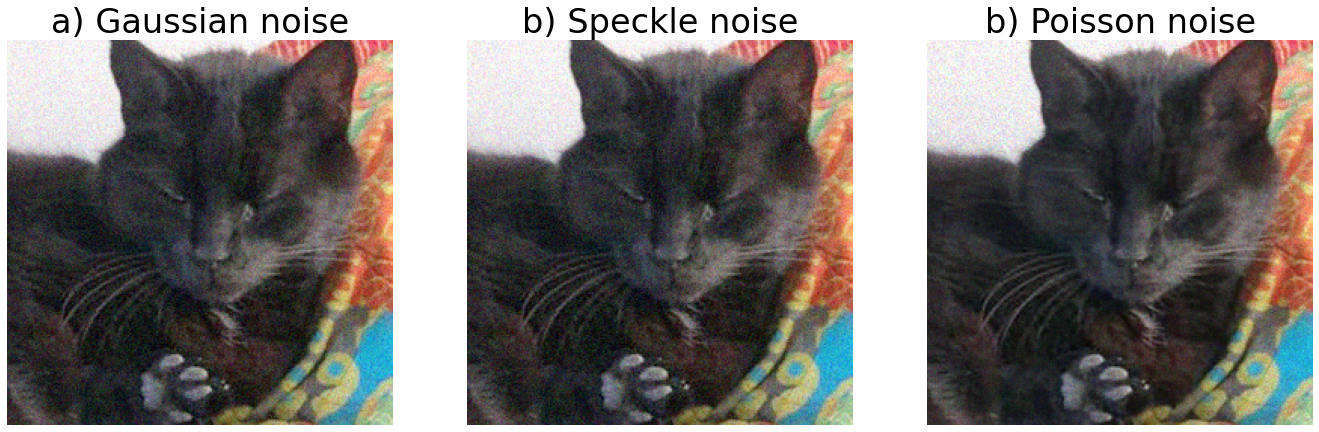

In [76]:

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 17),
                       sharex=True, sharey=True)
fig.tight_layout()
plt.gray()

noisy_gaussian = random_noise(image, var=sigma**2, seed = 2, mode = "gaussian")
noisy_speckle = random_noise(image, var=sigma**2, seed = 2, mode = "speckle")
noisy_po = random_noise(original_image, seed = 2, mode = "poisson")


#noisy_gaussian = rgb2gray(noisy_gaussian)


ax[0].imshow(noisy_gaussian)
ax[0].axis('off')
ax[0].set_title("a) Gaussian noise")

ax[1].imshow(noisy_gaussian)
ax[1].axis('off')
ax[1].set_title("b) Speckle noise")

ax[2].imshow(noisy_po)
ax[2].axis('off')
ax[2].set_title("b) Poisson noise")

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: name 'itses_image_ht' is not defined

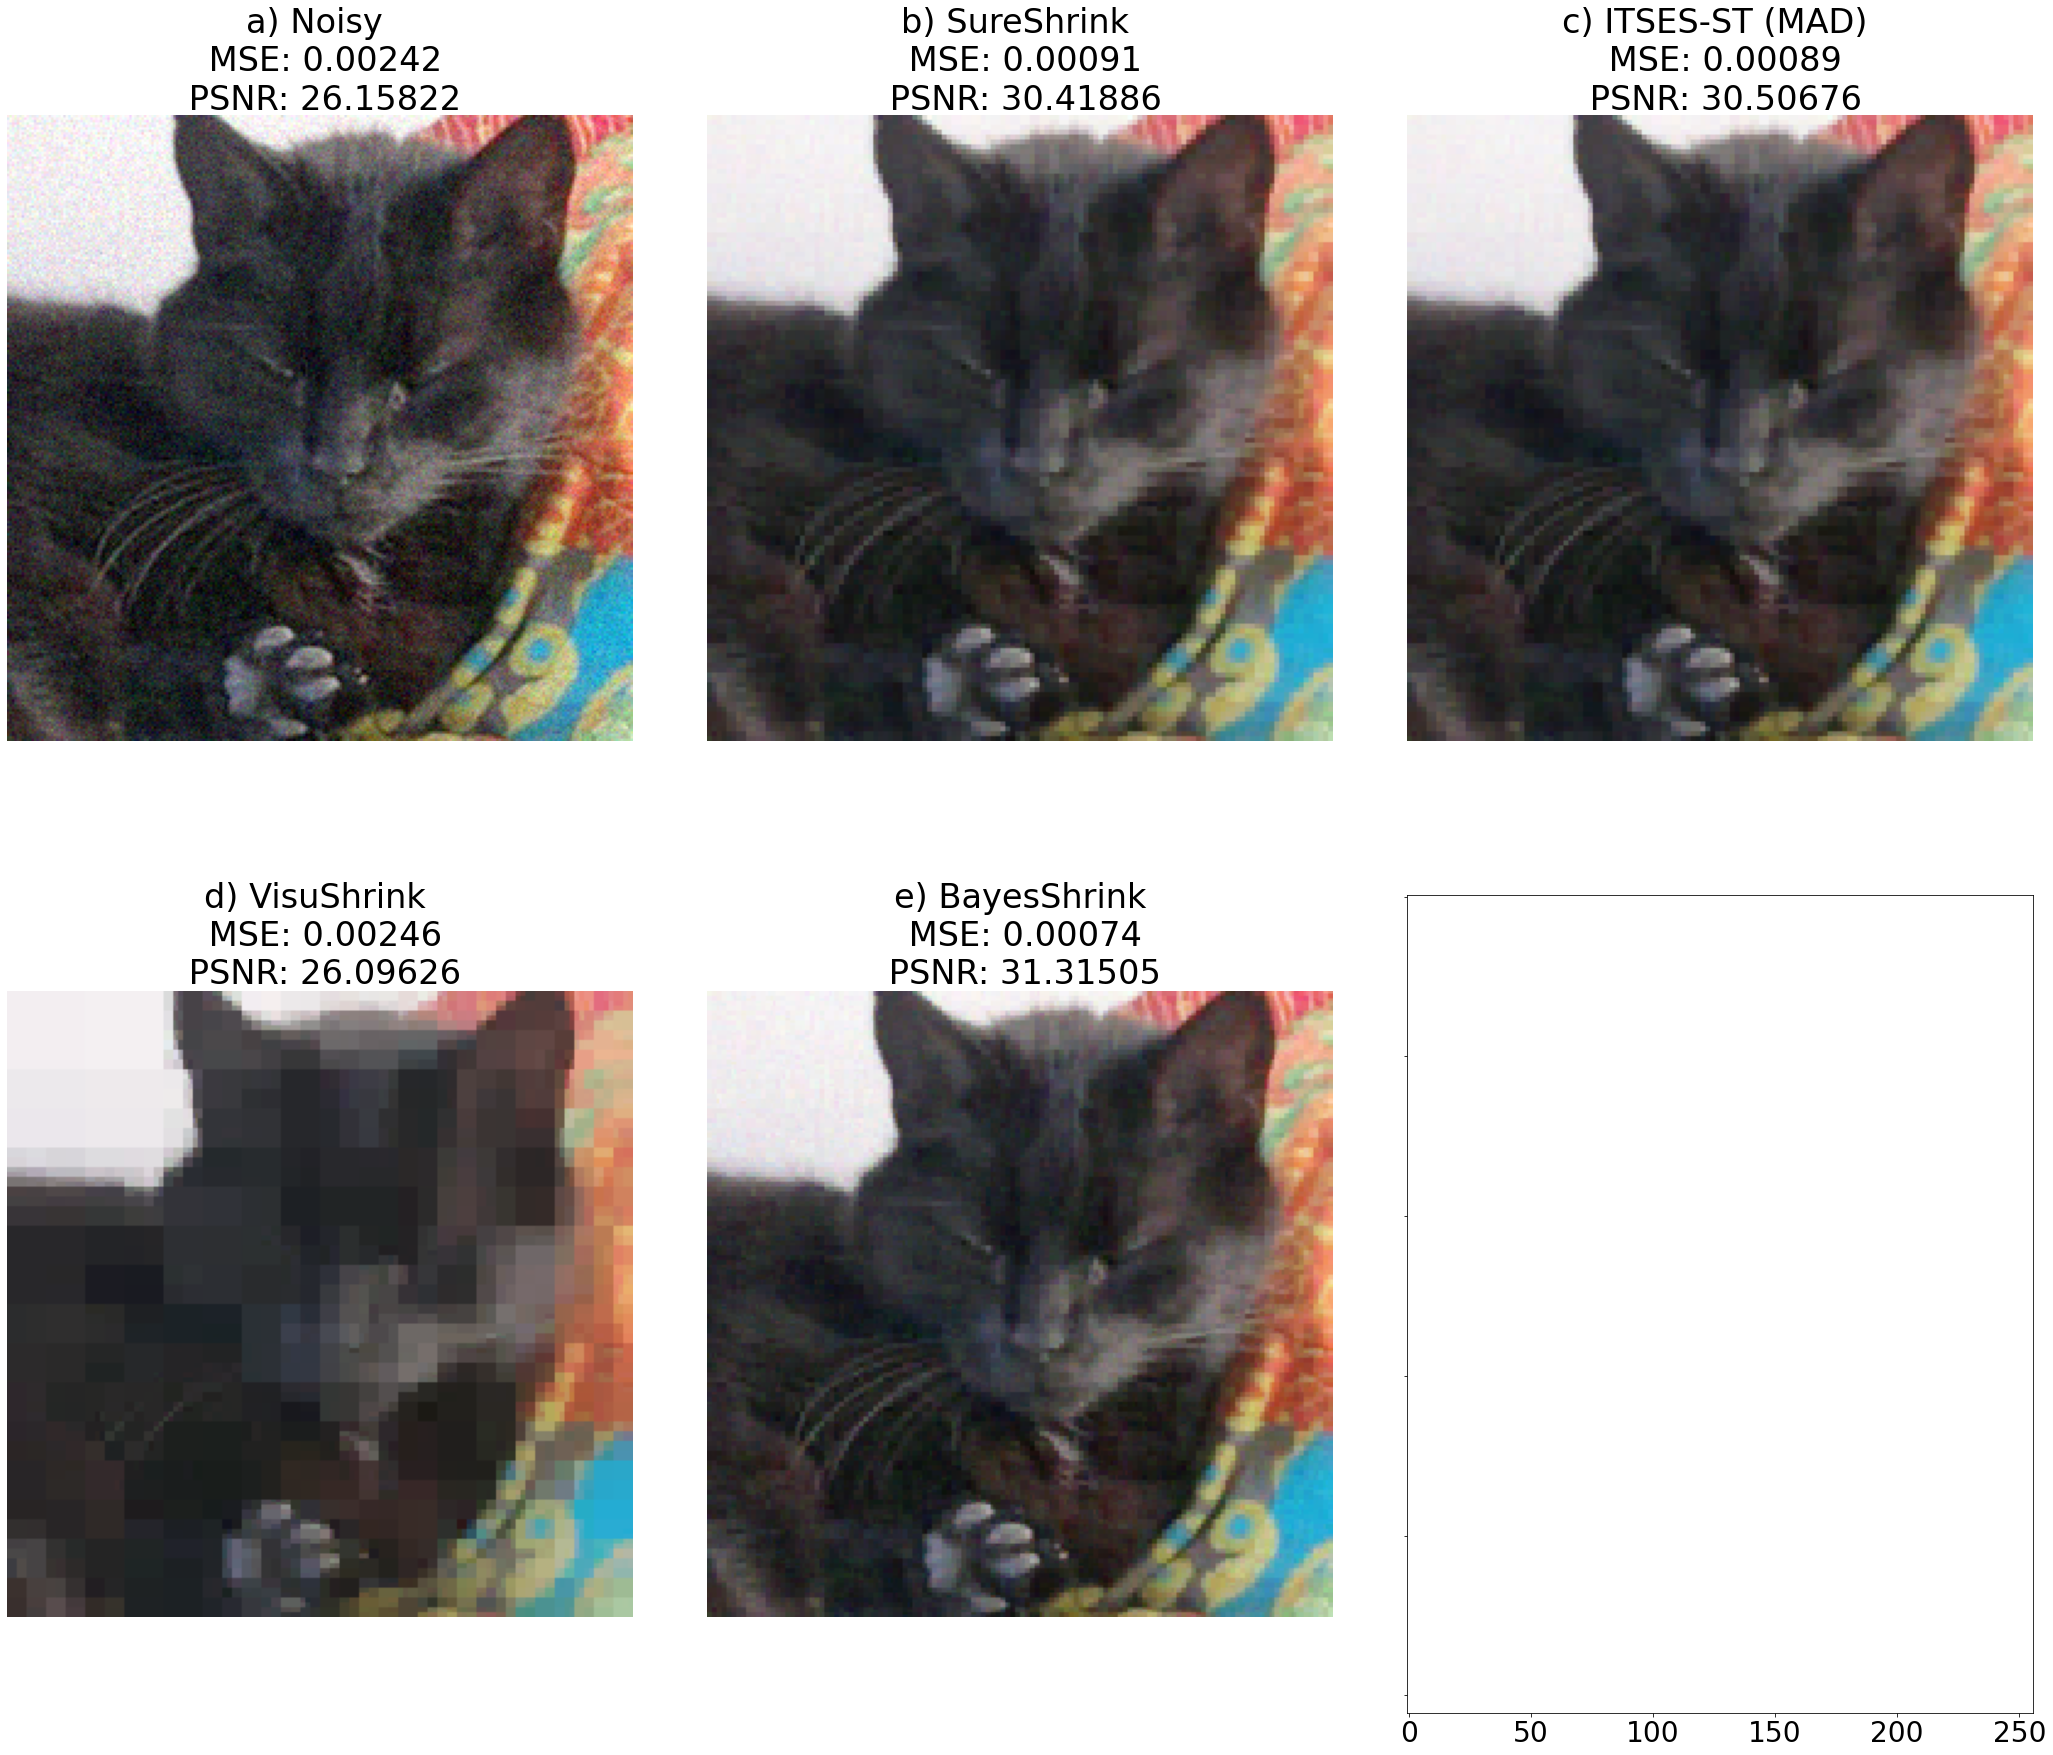

In [77]:
# Plot data
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 25),
                       sharex=True, sharey=True)
fig.tight_layout()
plt.gray()


psnr = str(round(peak_signal_noise_ratio(image, noisy),5))
mse = str(round(mean_squared_error(image, noisy),5))
ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('a) Noisy \n MSE: '+ mse + "\n PSNR: " + psnr)


psnr = str(round(peak_signal_noise_ratio(image, visu_image),5))
mse = str(round(mean_squared_error(image, visu_image),5))
ax[1, 0].imshow(visu_image)
ax[1, 0].axis('off')
ax[1, 0].set_title('d) VisuShrink \n MSE: '+ mse + "\n PSNR: " + psnr)

psnr = str(round(peak_signal_noise_ratio(image, bayes_image),5))
mse = str(round(mean_squared_error(image, bayes_image),5))
ax[1, 1].imshow(bayes_image)
ax[1, 1].axis('off')
ax[1, 1].set_title('e) BayesShrink\n MSE: '+ mse + "\n PSNR: " + psnr)

psnr = str(round(peak_signal_noise_ratio(image, ss_image),5))
mse = str(round(mean_squared_error(image, ss_image),5))
ax[0, 1].imshow(ss_image)
ax[0, 1].axis('off')
ax[0, 1].set_title('b) SureShrink \n MSE: '+ mse + "\n PSNR: " + psnr)


psnr = str(round(peak_signal_noise_ratio(image, itses_image_st),5))
mse = str(round(mean_squared_error(image, itses_image_st),5))
ax[0, 2].imshow(itses_image_st)
ax[0, 2].axis('off')
ax[0, 2].set_title('c) ITSES-ST (MAD) \n MSE: '+ mse + "\n PSNR: " + psnr)



psnr = str(round(peak_signal_noise_ratio(image, itses_image_ht),5))
mse = str(round(mean_squared_error(image, itses_image_ht),5))
ax[1, 2].imshow(itses_image_ht)
ax[1, 2].axis('off')
ax[1, 2].set_title('f) ITSES-HT (MAD)\n MSE: '+ mse + "\n PSNR: " + psnr)


plt.show()

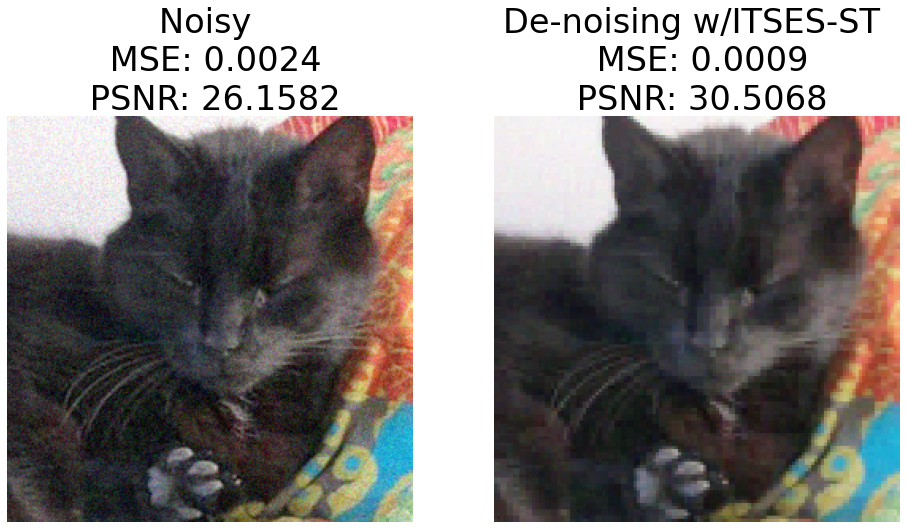

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9),
                       sharex=True, sharey=True)
plt.gray()

psnr = str(round(peak_signal_noise_ratio(image, noisy),4))
mse = str(round(mean_squared_error(image, noisy),4))
ax[0].imshow(noisy)
ax[0].axis('off')
ax[0].set_title('Noisy \n MSE: '+ mse + "\n PSNR: " + psnr)
#ax[0].set_title('Noisy')

psnr = str(round(peak_signal_noise_ratio(image, itses_image_st),4))
mse = str(round(mean_squared_error(image, itses_image_st),4))
ax[1].imshow(itses_image_st)
ax[1].axis('off')
ax[1].set_title('De-noising w/ITSES-ST \n MSE: '+ mse + "\n PSNR: " + psnr)
#ax[1].set_title("Proposed denoising method")

plt.savefig("output/figures//cat_small.pdf")
plt.show()